<a href="https://colab.research.google.com/github/AugustoBonifacio001/AugustoBonifacio001/blob/main/calculo_entropia_dos_sinais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from scipy.stats import entropy

# Função para calcular a entropia de um sinal
def calcular_entropia(sinal):
    hist, _ = np.histogram(sinal, bins=256, range=(0, 1))
    hist = hist / np.sum(hist)  # Normalizar o histograma para obter uma distribuição de probabilidade
    return entropy(hist, base=2)

def cosamp(Phi, u, s, tol=1e-10, max_iter=10):
    max_iter -= 1
    num_precision = 1e-12
    a = np.zeros(Phi.shape[1])
    v = u
    iter_count = 0
    halt = False
    while not halt:
        iter_count += 1
        y = np.abs(np.dot(np.transpose(Phi), v))
        Omega = [i for (i, val) in enumerate(y) if val > np.sort(y)[::-1][2 * s] and val > num_precision]
        T = np.union1d(Omega, a.nonzero()[0])
        b = np.dot(np.linalg.pinv(Phi[:, T]), u)
        igood = (np.abs(b) > np.sort(np.abs(b))[::-1][s]) & (np.abs(b) > num_precision)
        T = T[igood]
        a[T] = b[igood]
        v = u - np.dot(Phi[:, T], b[igood])
        halt = np.linalg.norm(v)/np.linalg.norm(u) < tol or iter_count > max_iter
    return a

def omp(Phi, u, s):
    omp_model = OrthogonalMatchingPursuit(n_nonzero_coefs=s)
    omp_model.fit(np.real(Phi), u)
    return omp_model.coef_

def calcular_PRD(original, reconstruido):
    return 100 * np.sqrt(np.sum((original - reconstruido)**2) / np.sum((original)**2))

# Parâmetros do sinal
n = 6 * 128
t = np.linspace(0.0, 0.1, num=n)
f1 = 60
f2 = 180

x = np.sin(2 * np.pi * f1 * t) + 0.3 * np.sin(2 * np.pi * f2 * t)

# Adicionar ruído gaussiano ao sinal original
media_ruido = 0
desvio_padrao_ruido = np.sqrt(np.var(x) / (10 ** (40 / 10)))  # Conversão de dB para magnitude do ruído
ruido_gaussiano = np.random.normal(media_ruido, desvio_padrao_ruido, len(x))
x_com_ruido = x + ruido_gaussiano

CR = 70
p = np.abs(np.round((n - n * CR) / 100).astype(int))
amostras_aleatorias = np.round((n - 1) * np.random.rand(p)).astype(int)
y = x_com_ruido[amostras_aleatorias]

# Calculando a FFT da matriz identidade para obter a matriz de esparsidade
Phi = np.fft.fft(np.eye(n, n))
CPhi = Phi[amostras_aleatorias, :]

# Reconstrução usando CoSaMP
s_reconstruido_cosamp = cosamp(CPhi, y, 10)
x_rec_cosamp = np.fft.ifft(s_reconstruido_cosamp)
PRD_cosamp = calcular_PRD(x, x_rec_cosamp.real)
entropia_cosamp_original = calcular_entropia(x)
entropia_cosamp_rec = calcular_entropia(x_rec_cosamp.real)

print(f'PRD do CoSaMP: {PRD_cosamp:.4f}')
print(f'Entropia do sinal original: {entropia_cosamp_original:.4f}')
print(f'Entropia do sinal reconstruído pelo CoSaMP: {entropia_cosamp_rec:.4f}')

# Reconstrução usando OMP
s_reconstruido_omp = omp(CPhi, y, 10)
x_rec_omp = np.fft.ifft(s_reconstruido_omp)
PRD_omp = calcular_PRD(x, x_rec_omp.real)
entropia_omp_original = calcular_entropia(x)
entropia_omp_rec = calcular_entropia(x_rec_omp.real)

print(f'PRD do OMP: {PRD_omp:.4f}')
print(f'Entropia do sinal original: {entropia_omp_original:.4f}')
print(f'Entropia do sinal reconstruído pelo OMP: {entropia_omp_rec:.4f}')


<ipython-input-2-ff21526bd65c>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  a[T] = b[igood]


PRD do CoSaMP: 99.9999
Entropia do sinal original: 6.7545
Entropia do sinal reconstruído pelo CoSaMP: 0.0000
PRD do OMP: 100.0000
Entropia do sinal original: 6.7545
Entropia do sinal reconstruído pelo OMP: 0.0000


Entropia do sinal original com ruído: 3.6340 bits
Entropia do sinal reconstruído com CoSaMP: 1.9603 bits


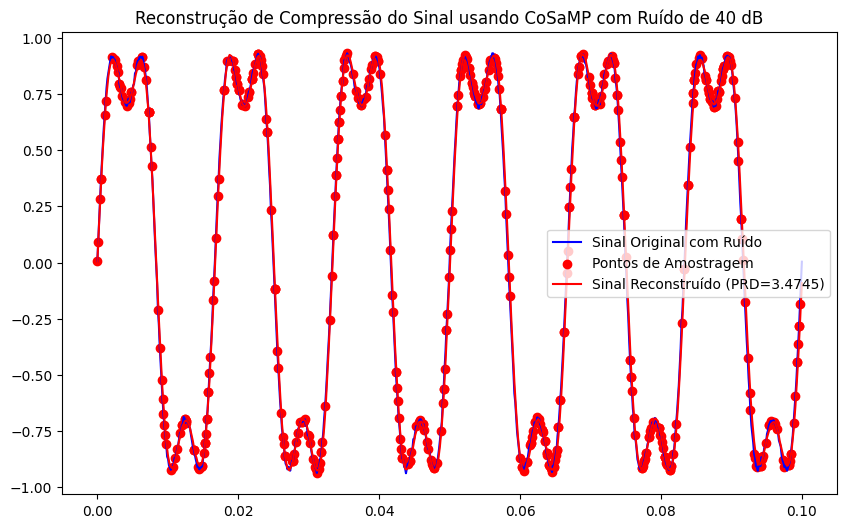

Entropia do sinal reconstruído com OMP: 2.0890 bits


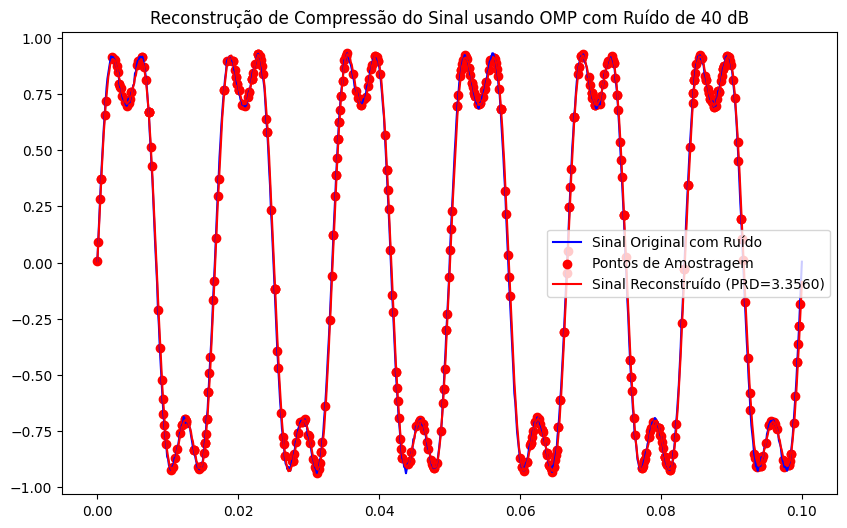

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
from scipy.stats import entropy

def cosamp(Phi, u, s, tol=1e-10, max_iter= 10):
    max_iter -= 1
    num_precision = 1e-12
    a = np.zeros(Phi.shape[1])
    v = u
    iter_count = 0
    halt = False
    while not halt:
        iter_count += 1
        y = np.abs(np.dot(np.transpose(Phi), v))
        Omega = [i for (i, val) in enumerate(y) if val > np.sort(y)[::-1][2 * s] and val > num_precision]
        T = np.union1d(Omega, a.nonzero()[0])
        b = np.dot(np.linalg.pinv(Phi[:, T]), u)
        igood = (np.abs(b) > np.sort(np.abs(b))[::-1][s]) & (np.abs(b) > num_precision)
        T = T[igood]
        a[T] = b[igood]
        v = u - np.dot(Phi[:, T], b[igood])
        halt = np.linalg.norm(v)/np.linalg.norm(u) < tol or iter_count > max_iter
    return a

def omp(Phi, u, s):
    omp_model = OrthogonalMatchingPursuit(n_nonzero_coefs=s)
    omp_model.fit(Phi, u)
    return omp_model.coef_

def calculate_mse(original, reconstructed):
    return 100 * np.sqrt(np.sum((original - reconstructed)**2) / np.sum((original)**2))


n = 6*128
t = np.linspace(0.0, 0.1, num=n)
f1 = 60
f2 = 180

x = np.sin(2 * np.pi * f1 * t) + 0.3 * np.sin(2 * np.pi * f2 * t)
# Adicionar ruído gaussiano ao sinal original
media_ruido = 0
desvio_padrao_ruido = np.sqrt(np.var(x) / (10 ** (40 / 10)))  # Conversão de dB para magnitude do ruído
ruido_gaussiano = np.random.normal(media_ruido, desvio_padrao_ruido, len(x))
x_com_ruido = x + ruido_gaussiano
CR = 70
p = np.abs(np.round((n - n * CR) / 100).astype(int))
amostras_aleatorias = np.round((n - 1) * np.random.rand(p)).astype(int)
y = x_com_ruido[amostras_aleatorias]


Phi = np.fft.fft(np.eye(n, n))
CPhi = np.imag(Phi[amostras_aleatorias, :])

s_reconstruido_cosamp = cosamp(CPhi, y, 10)
x_rec_cosamp = np.imag(np.fft.fft(s_reconstruido_cosamp))

mse_cosamp = calculate_mse(x, x_rec_cosamp)

# Calcular entropia do sinal original e reconstruído
entropy_original = entropy(np.abs(np.fft.fft(x_com_ruido)), base=2)
entropy_cosamp = entropy(np.abs(np.fft.fft(x_rec_cosamp)), base=2)

print(f'Entropia do sinal original com ruído: {entropy_original:.4f} bits')
print(f'Entropia do sinal reconstruído com CoSaMP: {entropy_cosamp:.4f} bits')

# Plotar resultado do CoSaMP
plt.figure(figsize=(10, 6))
plt.plot(t, x_com_ruido, 'b', label='Sinal Original com Ruído')
plt.scatter(t[amostras_aleatorias], x_com_ruido[amostras_aleatorias], color='red', label='Pontos de Amostragem')
plt.plot(t, x_rec_cosamp, 'r', label=f'Sinal Reconstruído (PRD={mse_cosamp:.4f})')
plt.title('Reconstrução de Compressão do Sinal usando CoSaMP com Ruído de 40 dB')
plt.legend()
plt.show()

# Executar o algoritmo OMP
s_reconstruido = omp(CPhi, y, 10)
x_rec = np.imag(np.fft.fft(s_reconstruido))
mse_omp = calculate_mse(x, x_rec)

# Calcular entropia do sinal reconstruído com OMP
entropy_omp = entropy(np.abs(np.fft.fft(x_rec)), base=2)

print(f'Entropia do sinal reconstruído com OMP: {entropy_omp:.4f} bits')

# Plotar resultado do OMP
plt.figure(figsize=(10, 6))
plt.plot(t, x_com_ruido, 'b', label='Sinal Original com Ruído')
plt.scatter(t[amostras_aleatorias], x_com_ruido[amostras_aleatorias], color='red', label='Pontos de Amostragem')
plt.plot(t, x_rec, 'r', label=f'Sinal Reconstruído (PRD={mse_omp:.4f})')
plt.title('Reconstrução de Compressão do Sinal usando OMP com Ruído de 40 dB')
plt.legend()
plt.show()
